<a href="https://colab.research.google.com/github/The-H4CKER/deep-option-pricer/blob/main/notebooks/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

## Setup

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np


In [2]:
DB_PATH = "sqlite:///data/options_data.db"
engine = create_engine(DB_PATH)

try:
  df = pd.read_sql_table("options", engine)
  print("Database loaded successfully!")
  print(f"Loaded {len(df)} records.")
except Exception as e:
  print(f"Error loading database: {e}")

Database loaded successfully!
Loaded 2097 records.


## Data Preparation

In [3]:
df['r'] = 0.05  # define risk-free rate

# added new feature
df['moneyness'] = df['stock_price'] / df['strike_price']

# One-hot encode the 'option_type' column ('call' -> 1, 'put' -> 0)
# Replaces 'option_type' col with 'option_type_put' which is either 0.0 or 1.0
df = pd.get_dummies(df, columns=['option_type'], drop_first=True, dtype=float)

features = ['stock_price', 'strike_price', 'dte', 'r', 'option_type_put', 'moneyness']
target = 'market_price'

# Explicitly define model's inputs (X) and output (y)
X = df[features].values
y = np.log(df[target].values.reshape(-1, 1))  # vector forma

# print(f"X shape: {X.shape}")
# print(f"y shape: {y.shape}")

# Perform standard 80-20 split on data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")

# Scale input features to similar scale (mean=0, std=1)
scaler = StandardScaler()

# scaler should only fit to training data to avoid data leak
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert NumPy arrays into PyTorch tensors.
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


## Visualising Market Price Distribution

--- Descriptive Statistics for Market Price ---
count    2097.000000
mean       36.490238
std        49.888302
min         0.010000
25%         0.640000
50%        10.050000
75%        59.130000
max       245.900000
Name: market_price, dtype: float64


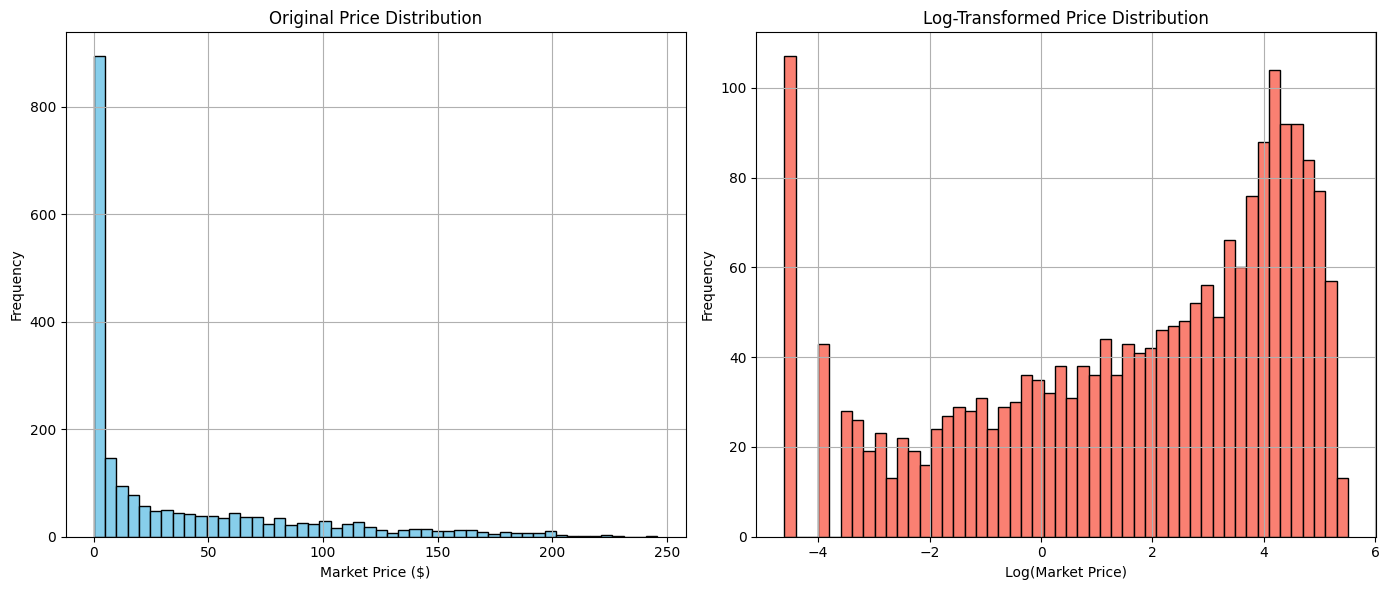

In [4]:
import matplotlib.pyplot as plt
import numpy as np

print("--- Descriptive Statistics for Market Price ---")
print(df['market_price'].describe())

plt.figure(figsize=(14, 6))

# Plot 1: Original Price Distribution
plt.subplot(1, 2, 1)
plt.hist(df['market_price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Original Price Distribution')
plt.xlabel('Market Price ($)')
plt.ylabel('Frequency')
plt.grid(True)

# Plot 2: Log-Transformed Price Distribution
# We filter for prices > 0 to avoid errors with log(0)
plt.subplot(1, 2, 2)
plt.hist(np.log(df[df['market_price'] > 0]['market_price']), bins=50, color='salmon', edgecolor='black')
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Market Price)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

## Build Neural Network

In [5]:

class OptionPricer(nn.Module):
  def __init__(self, input_size):
    super(OptionPricer, self).__init__()

    # A deeper and wider architecture with BatchNorm and Dropout
    self.layers = nn.Sequential(
        nn.Linear(input_size, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(128, 64),
        nn.ReLU(),

        nn.Linear(64, 1) # Output layer
    )

  def forward(self, x):
    '''Define forward propogation'''
    x = self.layers(x)
    return x

input_size = X_train_tensor.shape[1]
model = OptionPricer(input_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

model

OptionPricer(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)

## Training

--- Started Training with Early Stopping ---
Epoch [100/2000], Train Loss: 3.8809, Test RMSE: $48.4038
==> New best model saved at epoch 100 with RMSE: $48.4038
Epoch [200/2000], Train Loss: 1.1549, Test RMSE: $15.7863
==> New best model saved at epoch 200 with RMSE: $15.7863
Epoch [300/2000], Train Loss: 0.7849, Test RMSE: $13.0517
==> New best model saved at epoch 300 with RMSE: $13.0517
Epoch [400/2000], Train Loss: 0.6167, Test RMSE: $11.0348
==> New best model saved at epoch 400 with RMSE: $11.0348
Epoch [500/2000], Train Loss: 0.5471, Test RMSE: $10.3384
==> New best model saved at epoch 500 with RMSE: $10.3384
Epoch [600/2000], Train Loss: 0.5220, Test RMSE: $10.0677
==> New best model saved at epoch 600 with RMSE: $10.0677
Epoch [700/2000], Train Loss: 0.5190, Test RMSE: $10.3330
Epoch [800/2000], Train Loss: 0.4915, Test RMSE: $9.9989
==> New best model saved at epoch 800 with RMSE: $9.9989
Epoch [900/2000], Train Loss: 0.4549, Test RMSE: $10.1703
Epoch [1000/2000], Train Loss

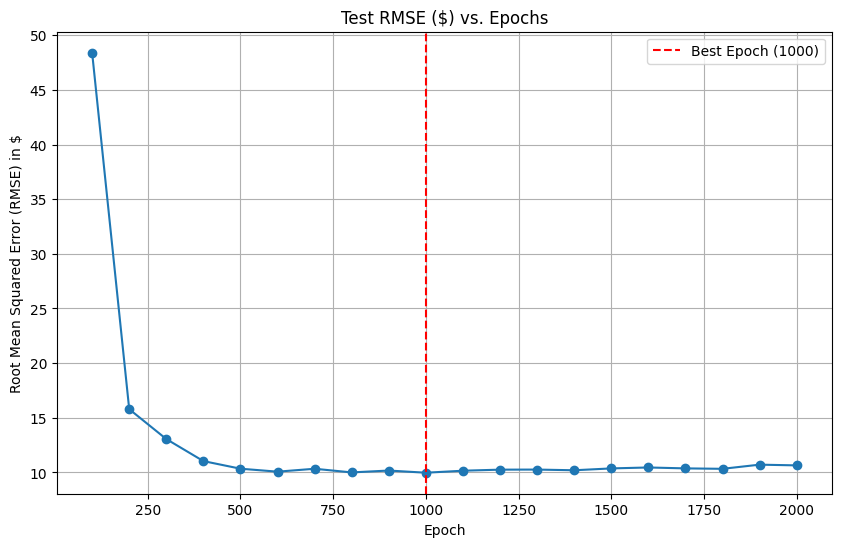

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR

# --- Re-instantiate everything to ensure a fresh start ---
input_size = X_train_tensor.shape[1]
model = OptionPricer(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = StepLR(optimizer, step_size=500, gamma=0.5)

# --- Setup for Training and Early Stopping ---
num_epochs = 2000
best_test_rmse = np.inf
best_epoch = -1
epoch_log = []
test_rmse_log = []

# --- The Training Loop  ---
print("--- Started Training with Early Stopping ---")
model.train()
for epoch in range(num_epochs):
    outputs = model(X_train_tensor) # Model predicts log-prices
    loss = criterion(outputs, y_train_tensor) # Loss is calculated on log-prices

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # --- Evaluation on Test Set ---
    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            test_outputs_log = model(X_test_tensor) # Log-price predictions

            # Convert log-predictions and log-actuals back to dollar prices
            # before calculating the RMSE for logging and early stopping.
            price_predictions = torch.exp(test_outputs_log)
            original_y_test = torch.exp(y_test_tensor)

            # Calculate loss and RMSE on the actual dollar prices
            test_loss_dollar = criterion(price_predictions, original_y_test)
            test_rmse_dollar = torch.sqrt(test_loss_dollar).item()

            epoch_log.append(epoch + 1)
            test_rmse_log.append(test_rmse_dollar)

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test RMSE: ${test_rmse_dollar:.4f}")

            # Check if this is the best model so far based on dollar-RMSE
            if test_rmse_dollar < best_test_rmse:
                best_test_rmse = test_rmse_dollar
                best_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"==> New best model saved at epoch {best_epoch} with RMSE: ${best_test_rmse:.4f}")

        model.train()

print("\n--- Training Finished ---")

# --- Load and Evaluate the Best Model ---
print("\n--- Final Results of the Best Model ---")
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    final_test_outputs_log = model(X_test_tensor)
    final_price_predictions = torch.exp(final_test_outputs_log)
    original_y_test = torch.exp(y_test_tensor)
    final_test_loss = criterion(final_price_predictions, original_y_test)
    final_rmse = torch.sqrt(final_test_loss).item()

print(f"Best model was found at epoch: {best_epoch}")
print(f"Final Test RMSE of Best Model: ${final_rmse:.4f}")

# --- Plotting the Results ---
plt.figure(figsize=(10, 6))
plt.plot(epoch_log, test_rmse_log, marker='o')
plt.title('Test RMSE ($) vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE) in $')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [7]:
model.eval()

with torch.no_grad():
    # Model outputs log-prices
    test_outputs_log = model(X_test_tensor)
    # Convert log values back to dollar prices before calculating RMSE
    price_predictions = torch.exp(test_outputs_log)
    original_y_test = torch.exp(y_test_tensor)
    # calculate loss on the correct dollar scale
    test_loss_dollar = criterion(price_predictions, original_y_test)
    test_rmse_dollar = torch.sqrt(test_loss_dollar).item()


print(f"\nFinal Model Performance on Unseen Test Data:")
print(f"Test Root Mean Squared Error (RMSE): ${test_rmse_dollar:.4f}")


Final Model Performance on Unseen Test Data:
Test Root Mean Squared Error (RMSE): $9.9709
